In [1]:
import pandas as pd
import numpy as np
#from category_encoders import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

In [2]:
restaurant_csv_path = "data/DOHMH_New_York_City_Restaurant_Inspection_Results.csv"
df = pd.read_csv(restaurant_csv_path)
df = df.dropna()
# Convert A, B, C to 3, 2, 1 for encodings, drop all other ratings
grades = ["A", "B", "C"]
df = df[df['GRADE'].isin(grades)]

df.loc[df["GRADE"] == "A", "GRADE"] = 3
df.loc[df["GRADE"] == "B", "GRADE"] = 2
df.loc[df["GRADE"] == "C", "GRADE"] = 1
# Check to see how often restaurants are inspected (to use for previous violations):
print("Range of times when a restaurant has been visited: ")
print(df.groupby(['CAMIS']).size().max())
print(df.groupby(['CAMIS']).size().min())

Range of times when a restaurant has been visited: 
36
1


In [3]:
# Replace violation code, zipcode and cuisine type with its average grade:
from category_encoders.target_encoder import TargetEncoder
target = df["GRADE"]
te = TargetEncoder(cols=["VIOLATION CODE", "ZIPCODE", "CUISINE DESCRIPTION"])
te.fit(df, target)
df = te.transform(df)

In [4]:
# Peform OHE on Boro and Critical Flag:
df = pd.get_dummies(df, columns=["BORO"])
df = pd.get_dummies(df, columns=["CRITICAL FLAG"])

In [5]:
print(df.columns)
df = df.drop(["DBA", 
              "BUILDING", 
              "STREET",
              "PHONE",
              "ACTION",
              "VIOLATION DESCRIPTION",
              "SCORE", 
              "Latitude",
              "Longitude",
              "Community Board",
              "Council District",
              "Census Tract", 
              "RECORD DATE",
              "INSPECTION DATE",
              "INSPECTION TYPE",
              "CRITICAL FLAG_Critical",
              "BIN",
              "NTA"], axis=1)

Index(['CAMIS', 'DBA', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'SCORE', 'GRADE', 'GRADE DATE', 'RECORD DATE',
       'INSPECTION TYPE', 'Latitude', 'Longitude', 'Community Board',
       'Council District', 'Census Tract', 'BIN', 'BBL', 'NTA', 'BORO_Bronx',
       'BORO_Brooklyn', 'BORO_Manhattan', 'BORO_Queens', 'BORO_Staten Island',
       'CRITICAL FLAG_Critical', 'CRITICAL FLAG_Not Critical'],
      dtype='object')


In [6]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import folium
from folium import plugins

In [8]:
df_rodent = pd.read_csv("data/Rodent_Inspection.csv")
print("Rodent_Inspection.csv has {0} rows and {1} columns.".format(df_rodent.shape[0],df_rodent.shape[1]))

Rodent_Inspection.csv has 2065411 rows and 20 columns.


In [9]:
# filter rows without LONGITUDE and LATITUDE
# input NaN values with zero for columns: X_COORD,Y_COORD,LATITUDE,LONGITUDE
df_rodent['LATITUDE'] = df_rodent['LATITUDE'].fillna(0)
df_rodent['LONGITUDE'] = df_rodent['LONGITUDE'].fillna(0)
df_rodent['X_COORD'] = df_rodent['X_COORD'].fillna(0)
df_rodent['Y_COORD'] = df_rodent['Y_COORD'].fillna(0)
df_rodent['LOCATION'] = df_rodent['LOCATION'].fillna('(0.0, 0.0)')
df_rodent[df_rodent['LOCATION'] == '(0.0, 0.0)']['LOCATION'] = 0

df_rodent.head()

/var/folders/_y/qzymmsdj5jj6nb7_yhb63h0r0000gn/T/ipykernel_95809/2478946688.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rodent[df_rodent['LOCATION'] == '(0.0, 0.0)']['LOCATION'] = 0


,INSPECTION_TYPE,JOB_TICKET_OR_WORK_ORDER_ID,JOB_ID,JOB_PROGRESS,BBL,BORO_CODE,BLOCK,LOT,HOUSE_NUMBER,STREET_NAME,ZIP_CODE,X_COORD,Y_COORD,LATITUDE,LONGITUDE,BOROUGH,INSPECTION_DATE,RESULT,APPROVED_DATE,LOCATION
0,Initial,11611986,PC6523781,1,2028800113,2,2880,113,NaN,SEDGWICK AVENUE,10453.0,0.0,0.0,0.0,0.0,Bronx,11/24/2009 10:31:42 AM,Passed,11/25/2009 08:28:08 AM,"(0.0, 0.0)"
1,Initial,12328443,PC6737067,1,2025390132,2,2539,132,10,MAJ WM DEEGAN BLVD,NaN,1003704.0,240136.0,0.0,0.0,Bronx,09/12/2017 02:45:42 PM,Passed,09/14/2017 02:41:03 PM,"(0.0, 0.0)"
2,Initial,11814495,PC6154122,1,1006380019,1,638,19,720,WEST 11 STREET,NaN,981787.0,207342.0,0.0,0.0,Manhattan,04/16/2012 03:39:54 PM,Passed,04/23/2012 11:19:22 AM,"(0.0, 0.0)"
3,Initial,12239212,PC7528187,1,4012720034,4,1272,34,3552B,73 STREET,NaN,1013891.0,212281.0,0.0,0.0,Queens,01/30/2017 10:30:29 AM,Rat Activity,02/02/2017 02:53:50 PM,"(0.0, 0.0)"
4,Initial,13265710,PC7744893,1,3011260085,3,1126,85,PACIFIC,STREET,11238.0,0.0,0.0,0.0,0.0,Brooklyn,07/30/2021 01:35:51 PM,Passed,08/02/2021 11:52:03 AM,"(0.0, 0.0)"


In [15]:
rows_to_filtered = (df_rodent[['X_COORD','Y_COORD','LATITUDE','LONGITUDE', 'LOCATION']] == 0 ).all(axis = 1)
df_filtered = df_rodent[-rows_to_filtered]

print(df_filtered.shape)
df_filtered.head()

(2065411, 20)


,INSPECTION_TYPE,JOB_TICKET_OR_WORK_ORDER_ID,JOB_ID,JOB_PROGRESS,BBL,BORO_CODE,BLOCK,LOT,HOUSE_NUMBER,STREET_NAME,ZIP_CODE,X_COORD,Y_COORD,LATITUDE,LONGITUDE,BOROUGH,INSPECTION_DATE,RESULT,APPROVED_DATE,LOCATION
0,Initial,11611986,PC6523781,1,2028800113,2,2880,113,NaN,SEDGWICK AVENUE,10453.0,0.0,0.0,0.0,0.0,Bronx,11/24/2009 10:31:42 AM,Passed,11/25/2009 08:28:08 AM,"(0.0, 0.0)"
1,Initial,12328443,PC6737067,1,2025390132,2,2539,132,10,MAJ WM DEEGAN BLVD,NaN,1003704.0,240136.0,0.0,0.0,Bronx,09/12/2017 02:45:42 PM,Passed,09/14/2017 02:41:03 PM,"(0.0, 0.0)"
2,Initial,11814495,PC6154122,1,1006380019,1,638,19,720,WEST 11 STREET,NaN,981787.0,207342.0,0.0,0.0,Manhattan,04/16/2012 03:39:54 PM,Passed,04/23/2012 11:19:22 AM,"(0.0, 0.0)"
3,Initial,12239212,PC7528187,1,4012720034,4,1272,34,3552B,73 STREET,NaN,1013891.0,212281.0,0.0,0.0,Queens,01/30/2017 10:30:29 AM,Rat Activity,02/02/2017 02:53:50 PM,"(0.0, 0.0)"
4,Initial,13265710,PC7744893,1,3011260085,3,1126,85,PACIFIC,STREET,11238.0,0.0,0.0,0.0,0.0,Brooklyn,07/30/2021 01:35:51 PM,Passed,08/02/2021 11:52:03 AM,"(0.0, 0.0)"


In [16]:
df_filtered[ -df_filtered['APPROVED_DATE'].isna() ]

,INSPECTION_TYPE,JOB_TICKET_OR_WORK_ORDER_ID,JOB_ID,JOB_PROGRESS,BBL,BORO_CODE,BLOCK,LOT,HOUSE_NUMBER,STREET_NAME,ZIP_CODE,X_COORD,Y_COORD,LATITUDE,LONGITUDE,BOROUGH,INSPECTION_DATE,RESULT,APPROVED_DATE,LOCATION
0,Initial,11611986,PC6523781,1,2028800113,2,2880,113,NaN,SEDGWICK AVENUE,10453.0,0.0,0.0,0.000000,0.000000,Bronx,11/24/2009 10:31:42 AM,Passed,11/25/2009 08:28:08 AM,"(0.0, 0.0)"
1,Initial,12328443,PC6737067,1,2025390132,2,2539,132,10,MAJ WM DEEGAN BLVD,NaN,1003704.0,240136.0,0.000000,0.000000,Bronx,09/12/2017 02:45:42 PM,Passed,09/14/2017 02:41:03 PM,"(0.0, 0.0)"
2,Initial,11814495,PC6154122,1,1006380019,1,638,19,720,WEST 11 STREET,NaN,981787.0,207342.0,0.000000,0.000000,Manhattan,04/16/2012 03:39:54 PM,Passed,04/23/2012 11:19:22 AM,"(0.0, 0.0)"
3,Initial,12239212,PC7528187,1,4012720034,4,1272,34,3552B,73 STREET,NaN,1013891.0,212281.0,0.000000,0.000000,Queens,01/30/2017 10:30:29 AM,Rat Activity,02/02/2017 02:53:50 PM,"(0.0, 0.0)"
4,Initial,13265710,PC7744893,1,3011260085,3,1126,85,PACIFIC,STREET,11238.0,0.0,0.0,0.000000,0.000000,Brooklyn,07/30/2021 01:35:51 PM,Passed,08/02/2021 11:52:03 AM,"(0.0, 0.0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2065406,Initial,12077865,PC6237979,1,1018720056,1,1872,56,234,WEST 101 STREET,10025.0,992493.0,229982.0,40.797979,-73.969824,Manhattan,05/21/2015 11:33:06 AM,Passed,05/29/2015 09:33:52 AM,"(40.797978962057, -73.969823514211)"
2065407,Initial,11592132,PC7287081,1,3014500014,3,1450,14,NaN,DEAN STREET,11233.0,0.0,0.0,40.674332,-73.907673,Brooklyn,10/22/2018 03:20:48 PM,Failed for Other R,10/23/2018 11:57:25 AM,"(40.6743321190373, -73.9076733823261)"
2065408,Compliance,12741039,PC6553418,2,2025170001,2,2517,1,75,WEST 168 STREET,10452.0,1005313.0,244859.0,40.838229,-73.923886,Bronx,02/17/2010 01:20:08 PM,Passed,02/22/2010 03:51:10 PM,"(40.838228583738, -73.923885933689)"
2065409,BAIT,2463771,PC7151393,1,3024370038,3,2437,38,337,SOUTH 4 STREET,11211.0,996920.0,197581.0,40.708717,-73.954214,Brooklyn,10/26/2012 10:06:14 AM,Bait applied,10/29/2012 08:04:29 AM,"(40.708716941804, -73.954213597843)"


In [17]:
# datetime column conversion
import datetime as dt 
df_filtered = df_filtered[ - df_filtered['INSPECTION_DATE'].isna() ]
df_filtered = df_filtered[ - df_filtered['APPROVED_DATE'].isna() ]
print(df_filtered.shape)

# convert datetime object
df_filtered['INSPECTION_DATE'] = [dt.datetime.strptime(str(date_string), '%m/%d/%Y %I:%M:%S %p') for date_string in df_filtered['INSPECTION_DATE'].values ]
df_filtered['APPROVED_DATE'] = [dt.datetime.strptime(str(date_string), '%m/%d/%Y %I:%M:%S %p') for date_string in df_filtered['APPROVED_DATE'].values ]

(2063091, 20)


In [18]:
# Drop rows without result, which is the label
df_filtered = df_filtered[-df_filtered['RESULT'].isna()]
df_filtered.drop(columns=['LOCATION','X_COORD','Y_COORD'], inplace=True)
df_filtered = df_filtered[(df_filtered.LATITUDE != 0) & (df_filtered.LONGITUDE != 0)]
# write cleaned data to csv
# df_filtered.to_csv('data/Rodent_Inspection_Cleaned.csv')
print(df_filtered.shape)

(2044392, 17)


In [19]:
water_tank = pd.read_csv('data/Self-Reported_Drinking_Water_Tank_Inspection_Results.csv')
features = ['BIN','BOROUGH','ZIP','STREET_NAME','BLOCK', 'LOT','REPORTING_YEAR','TANK_NUM','INSPECTION_DATE',
           'GI_RESULT_INTERNAL_STRUCTURE','GI_RESULT_EXTERNAL_STRUCTURE','GI_RESULT_OVERFLOW_PIPES','GI_RESULT_ACCESS_LADDERS',
            'GI_RESULT_AIR_VENTS','GI_RESULT_ROOF_ACCESS','SI_RESULT_SEDIMENT','SI_RESULT_BIOLOGICAL_GROWTH','SI_RESULT_DEBRIS_INSECTS',
            'SI_RESULT_RODENT_BIRD','MEET_STANDARDS','LATITUDE','LONGITUDE','BBL']
water_tank_df = water_tank[features]

In [20]:
water_tank_df_c = water_tank_df.dropna()
water_tank_df.columns.values

array(['BIN', 'BOROUGH', 'ZIP', 'STREET_NAME', 'BLOCK', 'LOT',
       'REPORTING_YEAR', 'TANK_NUM', 'INSPECTION_DATE',
       'GI_RESULT_INTERNAL_STRUCTURE', 'GI_RESULT_EXTERNAL_STRUCTURE',
       'GI_RESULT_OVERFLOW_PIPES', 'GI_RESULT_ACCESS_LADDERS',
       'GI_RESULT_AIR_VENTS', 'GI_RESULT_ROOF_ACCESS',
       'SI_RESULT_SEDIMENT', 'SI_RESULT_BIOLOGICAL_GROWTH',
       'SI_RESULT_DEBRIS_INSECTS', 'SI_RESULT_RODENT_BIRD',
       'MEET_STANDARDS', 'LATITUDE', 'LONGITUDE', 'BBL'], dtype=object)

In [21]:
categorical_features = ['REPORTING_YEAR','BOROUGH', 'GI_RESULT_INTERNAL_STRUCTURE','GI_RESULT_EXTERNAL_STRUCTURE','GI_RESULT_OVERFLOW_PIPES','GI_RESULT_ACCESS_LADDERS',
            'GI_RESULT_AIR_VENTS','GI_RESULT_ROOF_ACCESS','SI_RESULT_SEDIMENT','SI_RESULT_BIOLOGICAL_GROWTH','SI_RESULT_DEBRIS_INSECTS',
            'SI_RESULT_RODENT_BIRD']
target = ['MEET_STANDARDS']
feat = categorical_features.copy()

In [22]:
df_2020 = water_tank_df_c[water_tank_df_c.REPORTING_YEAR == 2020]
df_2020 = df_2020[df_2020.MEET_STANDARDS == 'Y']

In [23]:
df_merged=pd.merge(water_tank_df_c,df_filtered, on='BBL')
df_merged_final=pd.merge(df_merged,df,on='BBL')

In [24]:
df_merged_final.head()

,BIN,BOROUGH_x,ZIP,STREET_NAME_x,BLOCK_x,LOT_x,REPORTING_YEAR,TANK_NUM,INSPECTION_DATE_x,GI_RESULT_INTERNAL_STRUCTURE,...,CUISINE DESCRIPTION,VIOLATION CODE,GRADE,GRADE DATE,BORO_Bronx,BORO_Brooklyn,BORO_Manhattan,BORO_Queens,BORO_Staten Island,CRITICAL FLAG_Not Critical
0,1024904,MANHATTAN,10019,WEST 58 STREET,1029,36,2017,2,05/12/2017,N,...,2.835189,2.810504,3,10/04/2017,0,0,1,0,0,0
1,1024904,MANHATTAN,10019,WEST 58 STREET,1029,36,2017,2,05/12/2017,N,...,2.835189,2.622041,3,04/17/2019,0,0,1,0,0,0
2,1024904,MANHATTAN,10019,WEST 58 STREET,1029,36,2017,2,05/12/2017,N,...,2.971615,2.847256,3,08/05/2019,0,0,1,0,0,1
3,1024904,MANHATTAN,10019,WEST 58 STREET,1029,36,2017,2,05/12/2017,N,...,2.971615,2.847256,3,08/05/2019,0,0,1,0,0,1
4,1024904,MANHATTAN,10019,WEST 58 STREET,1029,36,2017,2,05/12/2017,N,...,2.971615,2.909940,3,08/13/2018,0,0,1,0,0,1


In [25]:
water_tank_df_c.head()

,BIN,BOROUGH,ZIP,STREET_NAME,BLOCK,LOT,REPORTING_YEAR,TANK_NUM,INSPECTION_DATE,GI_RESULT_INTERNAL_STRUCTURE,...,GI_RESULT_AIR_VENTS,GI_RESULT_ROOF_ACCESS,SI_RESULT_SEDIMENT,SI_RESULT_BIOLOGICAL_GROWTH,SI_RESULT_DEBRIS_INSECTS,SI_RESULT_RODENT_BIRD,MEET_STANDARDS,LATITUDE,LONGITUDE,BBL
4,4047313,QUEENS,11368,57 AVENUE,1918,45,2020,1,06/30/2020,N,...,N,N,N,N,N,N,Y,40.736848,-73.865062,4.019180e+09
12,1020567,MANHATTAN,10010,2 AVENUE,927,55,2019,1,09/28/2019,N,...,N,N,N,N,N,N,Y,40.737124,-73.981449,1.009270e+09
13,2083518,BRONX,10463,KAPPOCK STREET,5750,357,2018,1,06/14/2018,N,...,N,N,N,N,N,N,Y,40.881931,-73.919747,2.057500e+09
18,1019613,MANHATTAN,10003,East 20th Street,901,6,2018,1,05/19/2018,N,...,N,N,N,N,N,N,Y,40.736468,-73.983311,1.009010e+09
22,1074772,MANHATTAN,10025,CENTRAL PARK WEST,1833,7502,2018,1,11/07/2018,N,...,N,N,N,N,N,N,Y,40.792841,-73.964709,1.018338e+09


In [26]:
dfw=water_tank_df_c.drop(['ZIP','BIN','STREET_NAME', 'BLOCK', 'LOT','LATITUDE', 'LONGITUDE','BOROUGH'],axis=1)


In [27]:
dfw.columns

Index(['REPORTING_YEAR', 'TANK_NUM', 'INSPECTION_DATE',
       'GI_RESULT_INTERNAL_STRUCTURE', 'GI_RESULT_EXTERNAL_STRUCTURE',
       'GI_RESULT_OVERFLOW_PIPES', 'GI_RESULT_ACCESS_LADDERS',
       'GI_RESULT_AIR_VENTS', 'GI_RESULT_ROOF_ACCESS', 'SI_RESULT_SEDIMENT',
       'SI_RESULT_BIOLOGICAL_GROWTH', 'SI_RESULT_DEBRIS_INSECTS',
       'SI_RESULT_RODENT_BIRD', 'MEET_STANDARDS', 'BBL'],
      dtype='object')

In [28]:
import numpy as np
dfw['MEET_STANDARDS'] = np.where(dfw['MEET_STANDARDS'] == 'Y', 1, dfw['MEET_STANDARDS'])
dfw['MEET_STANDARDS'] = np.where(dfw['MEET_STANDARDS'] == 'N', 0, dfw['MEET_STANDARDS'])

In [29]:
(1-np.sum(dfw['MEET_STANDARDS']/len(dfw)))*len(dfw)

2.9999999988275583

In [30]:
temp=dfw.loc(dfw['MEET_STANDARDS'].to_frame==0)

In [31]:
temp=dfw.loc[dfw['MEET_STANDARDS'] == 'N']
temp

,REPORTING_YEAR,TANK_NUM,INSPECTION_DATE,GI_RESULT_INTERNAL_STRUCTURE,GI_RESULT_EXTERNAL_STRUCTURE,GI_RESULT_OVERFLOW_PIPES,GI_RESULT_ACCESS_LADDERS,GI_RESULT_AIR_VENTS,GI_RESULT_ROOF_ACCESS,SI_RESULT_SEDIMENT,SI_RESULT_BIOLOGICAL_GROWTH,SI_RESULT_DEBRIS_INSECTS,SI_RESULT_RODENT_BIRD,MEET_STANDARDS,BBL


In [32]:
pd.unique(dfw['MEET_STANDARDS'])

array([1, 0], dtype=object)

In [33]:
dfr=df_filtered.drop(['ZIP_CODE','BORO_CODE', 'BLOCK', 'LOT', 'HOUSE_NUMBER',
       'STREET_NAME', 'ZIP_CODE', 'LATITUDE', 'LONGITUDE', 'BOROUGH'],axis=1)
dfr.columns

Index(['INSPECTION_TYPE', 'JOB_TICKET_OR_WORK_ORDER_ID', 'JOB_ID',
       'JOB_PROGRESS', 'BBL', 'INSPECTION_DATE', 'RESULT', 'APPROVED_DATE'],
      dtype='object')

In [34]:
dfr.head()
dfr['RESULT'] = np.where(dfr['RESULT'] == 'Rat Activity', 1, dfr['RESULT'])
dfr['RESULT'] = np.where(dfr['RESULT'] == 'Failed for Other R', 1, dfr['RESULT'])
dfr['RESULT'] = np.where(dfr['RESULT'] != 1, 0, dfr['RESULT'])

In [35]:
np.sum(dfr['RESULT'])/len(dfr)

0.2326065646901377

In [36]:
dfr['APPROVED_DATE']

191       2022-02-07 11:24:21
401       2017-07-26 10:19:39
474       2019-08-13 10:16:04
479       2018-09-27 10:52:18
553       2022-02-14 09:08:10
                  ...        
2065406   2015-05-29 09:33:52
2065407   2018-10-23 11:57:25
2065408   2010-02-22 15:51:10
2065409   2012-10-29 08:04:29
2065410   2011-05-04 11:31:01
Name: APPROVED_DATE, Length: 2044392, dtype: datetime64[ns]

In [37]:
dfr=dfr.drop(['JOB_ID','JOB_TICKET_OR_WORK_ORDER_ID'],axis=1)

In [38]:
from datetime import datetime
benchMark = datetime.strptime('20190101', "%Y%m%d")
dfr=dfr.loc[dfr['INSPECTION_DATE']>benchMark]

In [39]:
#Eliminate the critical flag
import datetime as dt 
print(df['GRADE DATE'])
#dfre=df.loc[df['GRADE DATE']>benchMark]
df['GRADE DATE'] = [dt.datetime.strptime(str(date_string), '%m/%d/%Y') for date_string in df['GRADE DATE'].values]

0         08/26/2021
2         09/18/2018
3         10/23/2019
4         05/30/2017
5         06/07/2019
             ...    
334466    10/23/2019
334469    12/17/2021
334472    03/19/2019
334474    02/15/2018
334475    09/26/2019
Name: GRADE DATE, Length: 154774, dtype: object


In [40]:
benchMark = datetime.strptime('20190101', "%Y%m%d")
dfre=df.loc[df['GRADE DATE']>benchMark]

In [41]:
#Machine learning model part 
#we drop the critical flag from our data restaurant to avoid collinearity 
dfre=dfre.drop('CRITICAL FLAG_Not Critical', axis=1)

In [42]:
df_final=pd.merge(dfre,dfr,on='BBL')


In [43]:
df_final=df_final.drop('APPROVED_DATE',axis=1)

In [44]:
test=df_final.loc[df_final['GRADE DATE'].dt.year==df_final['INSPECTION_DATE'].dt.year]

In [91]:
dfr.drop(columns='APPROVED_DATE').drop_duplicates()  # 462804
dfr.drop(columns=['APPROVED_DATE', 'RESULT']).drop_duplicates()  # 462795
dfr.drop(columns=['APPROVED_DATE', 'RESULT', 'JOB_PROGRESS', 'INSPECTION_TYPE']).drop_duplicates()  # 462616
dfr.drop(columns=['APPROVED_DATE', 'JOB_PROGRESS', 'INSPECTION_TYPE']).drop_duplicates()  # 462627

# Whenever it failed (same date in the same BBL), make it failed

,BBL,INSPECTION_DATE,RESULT
191,3048960003,2022-02-04 12:00:06,1
474,1004000057,2019-08-12 13:50:23,1
553,3012380033,2022-02-11 15:47:00,0
554,2031140071,2022-02-11 11:40:56,0
555,3017860039,2022-02-10 10:43:00,0
...,...,...,...
2065383,2053860036,2019-10-22 11:30:05,0
2065389,1021700019,2019-07-23 12:55:41,0
2065395,2054170140,2019-04-04 12:35:04,0
2065399,1015260034,2019-12-05 13:41:35,0


In [82]:
df_final.head(10)
# get the most recent inspection for each BBL

,CAMIS,ZIPCODE,CUISINE DESCRIPTION,VIOLATION CODE,GRADE,GRADE DATE,BBL,BORO_Bronx,BORO_Brooklyn,BORO_Manhattan,BORO_Queens,BORO_Staten Island,INSPECTION_TYPE,JOB_PROGRESS,INSPECTION_DATE,RESULT
0,41262792,2.620155,2.778468,2.909940,3,2021-08-26,1.021410e+09,0,0,1,0,0,Initial,1,2019-06-20 15:20:03,1
1,41262792,2.620155,2.778468,2.909940,3,2021-08-26,1.021410e+09,0,0,1,0,0,Initial,1,2019-02-15 13:15:26,0
2,41005529,2.620155,2.682366,2.909940,3,2022-03-08,1.021410e+09,0,0,1,0,0,Initial,1,2019-06-20 15:20:03,1
3,41005529,2.620155,2.682366,2.909940,3,2022-03-08,1.021410e+09,0,0,1,0,0,Initial,1,2019-02-15 13:15:26,0
4,41262792,2.620155,2.778468,2.909940,3,2019-07-22,1.021410e+09,0,0,1,0,0,Initial,1,2019-06-20 15:20:03,1
5,41262792,2.620155,2.778468,2.909940,3,2019-07-22,1.021410e+09,0,0,1,0,0,Initial,1,2019-02-15 13:15:26,0
6,41262792,2.620155,2.778468,2.909940,3,2019-07-22,1.021410e+09,0,0,1,0,0,Initial,1,2019-06-20 15:20:03,1
7,41262792,2.620155,2.778468,2.909940,3,2019-07-22,1.021410e+09,0,0,1,0,0,Initial,1,2019-02-15 13:15:26,0
8,41005529,2.620155,2.682366,2.665217,3,2022-03-08,1.021410e+09,0,0,1,0,0,Initial,1,2019-06-20 15:20:03,1
9,41005529,2.620155,2.682366,2.665217,3,2022-03-08,1.021410e+09,0,0,1,0,0,Initial,1,2019-02-15 13:15:26,0


In [45]:
y=df_final['GRADE']
X=df_final.loc[:,df_final.columns!='GRADE']

In [46]:
X=X.drop(['CAMIS','BBL','INSPECTION_TYPE'],axis=1)

In [47]:
X

,ZIPCODE,CUISINE DESCRIPTION,VIOLATION CODE,GRADE DATE,BORO_Bronx,BORO_Brooklyn,BORO_Manhattan,BORO_Queens,BORO_Staten Island,JOB_PROGRESS,INSPECTION_DATE,RESULT
0,2.620155,2.778468,2.909940,2021-08-26,0,0,1,0,0,1,2019-06-20 15:20:03,1
1,2.620155,2.778468,2.909940,2021-08-26,0,0,1,0,0,1,2019-02-15 13:15:26,0
2,2.620155,2.682366,2.909940,2022-03-08,0,0,1,0,0,1,2019-06-20 15:20:03,1
3,2.620155,2.682366,2.909940,2022-03-08,0,0,1,0,0,1,2019-02-15 13:15:26,0
4,2.620155,2.778468,2.909940,2019-07-22,0,0,1,0,0,1,2019-06-20 15:20:03,1
...,...,...,...,...,...,...,...,...,...,...,...,...
210174,2.886512,2.654391,2.909940,2019-08-09,0,0,1,0,0,1,2022-02-07 15:40:59,0
210175,2.886512,2.654391,2.909940,2019-08-09,0,0,1,0,0,1,2019-04-29 16:33:57,0
210176,2.793313,2.682366,2.530192,2021-12-17,1,0,0,0,0,1,2019-09-24 14:45:54,1
210177,2.793313,2.682366,2.530192,2021-12-17,1,0,0,0,0,1,2019-08-22 10:14:05,0


In [48]:
y=test['GRADE']
#Matching for the same year as the inspection
X=test.drop(['CAMIS','BBL','INSPECTION_TYPE','GRADE','INSPECTION_DATE','GRADE DATE'],axis=1)

In [49]:
X

,ZIPCODE,CUISINE DESCRIPTION,VIOLATION CODE,BORO_Bronx,BORO_Brooklyn,BORO_Manhattan,BORO_Queens,BORO_Staten Island,JOB_PROGRESS,RESULT
4,2.620155,2.778468,2.909940,0,0,1,0,0,1,1
5,2.620155,2.778468,2.909940,0,0,1,0,0,1,0
6,2.620155,2.778468,2.909940,0,0,1,0,0,1,1
7,2.620155,2.778468,2.909940,0,0,1,0,0,1,0
10,2.620155,2.682366,2.913569,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
210165,2.682566,2.686047,2.810504,0,0,0,1,0,1,1
210166,2.807181,2.888570,2.909940,0,0,1,0,0,1,0
210171,2.835430,2.837398,2.909940,0,1,0,0,0,1,0
210173,2.886512,2.654391,2.909940,0,0,1,0,0,1,0


In [50]:
y.to_frame()

,GRADE
4,3
5,3
6,3
7,3
10,3
...,...
210165,3
210166,3
210171,3
210173,3


In [51]:
#Machine learning part
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
lr=LinearRegression()
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test= train_test_split(X, y, test_size=0.2) 

In [52]:
X_train = np.hstack([np.ones((X_train.shape[0], 1)),X_train])
X_test = np.hstack([np.ones((X_test.shape[0], 1)),X_test])

In [53]:
class LinearRegression1():
    '''
    Linear regression model with L2-regularization (i.e. ridge regression).

    Attributes
    ----------
    alpha: regularization parameter
    w: (n x 1) weight vector
    '''
    def __init__(self, alpha=0):
        self.alpha = alpha
        self.w = None

    def train(self, X, y):
        '''Trains model using ridge regression closed-form solution 
        (sets w to its optimal value).
        
        Parameters
        ----------
        X : (m x n) feature matrix
        y: (m x 1) label vector
        
        Returns
        -------
        None
        '''
        ### Your code here
        #We can condense our formula in the following way, so that we dont have to have pieces
        self.w = np.linalg.inv(X.transpose().dot(X) + self.alpha*np.identity(X.shape[1])).dot(X.transpose()).dot(y)


        
    def predict(self, X):
        '''Predicts on X using trained model.
        
        Parameters
        ----------
        X : (m x n) feature matrix
        
        Returns
        -------
        y_pred: (m x 1) prediction vector
        '''
        
        ### Your code here
        y_pred = X.dot(self.w) 
        return y_pred

In [57]:
np.asarray(X_train,dtype='float')[0]

array([1.        , 2.83791103, 2.88857012, 2.90994039, 0.        ,
       0.        , 1.        , 0.        , 0.        , 1.        ,
       0.        ])

[ 5.33120756e+01  2.80773745e+00  5.64588147e+00  9.51440232e+00
 -8.78891852e+01 -9.92527905e+01 -8.62393167e+01 -9.02182568e+01
 -8.96275219e+01  6.53335026e-04 -2.25218180e-03]


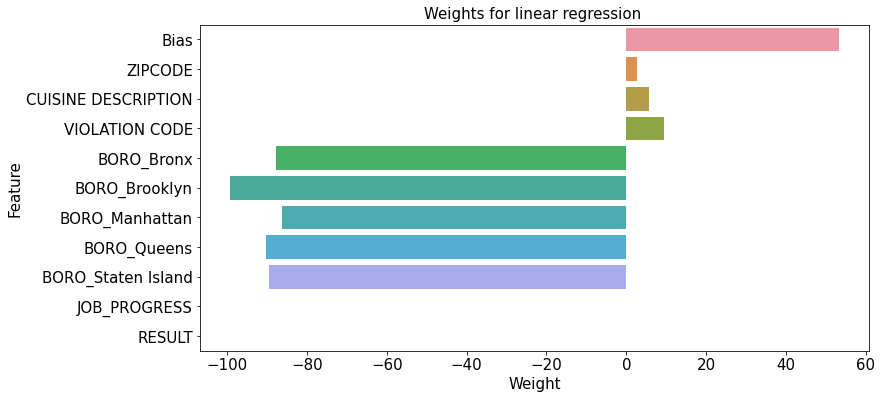

In [54]:
#Linear regression
model=LinearRegression1()
model.train(np.asarray(X_train,dtype='float'),np.asarray(y_train,dtype='float'))
print(model.w)
# y_pred=.predict(X_test)
# y_check=np.asarray(y_test)
# y_pred=np.asarray(y_pred)
# mse=np.sum((y_pred-y_check)**2)/len(y_pred)
# print(mse)
coef_names = ['Bias']+X.columns.tolist()
model_coefs= model.w
plt.figure(figsize = (12, 6))
sns.barplot(y= coef_names, x = model_coefs)
plt.title('Weights for linear regression ', fontsize = 15)
plt.ylabel('Feature', fontsize = 15)
plt.xlabel('Weight', fontsize = 15)
plt.tick_params(labelsize = 15)

In [92]:
#Logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
modell=LogisticRegression(multi_class='ovr')
modell.fit(X_train,y_train.astype(int))
# logreg=OneVsRestClassifier()
# logreg.fit(estimator=modell)

/Users/clarissarjtai/miniforge3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/clarissarjtai/miniforge3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

LogisticRegression(multi_class='ovr')

In [104]:
modell.coef_[0]

array([ 1.33869214e+01, -7.39090898e+00, -1.97673677e+00, -2.90703544e+00,
        2.33367801e+00,  2.90452339e+00,  2.80108412e+00,  2.35671995e+00,
        2.99091593e+00, -3.15533320e-02, -1.28523539e-02])

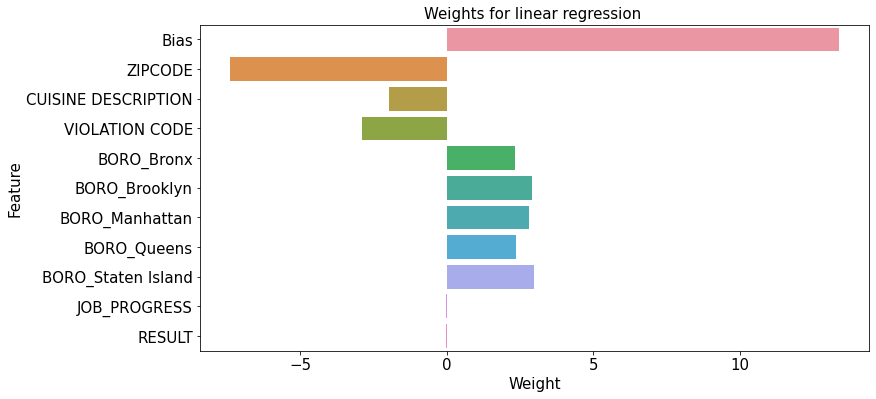

In [109]:

plt.figure(figsize = (12, 6))
sns.barplot(y= coef_names, x = modell.coef_[0])
plt.title('Weights for linear regression ', fontsize = 15)
plt.ylabel('Feature', fontsize = 15)
plt.xlabel('Weight', fontsize = 15)
plt.tick_params(labelsize = 15)

In [93]:
y_pred=modell.predict(X_test)
error=[]
s=y_pred-y_test 
np.sum(s)/len(y_pred)

0.2861802367721672

In [58]:
ar=np.asarray(s)

In [60]:
for i in range(len(ar)):
    if ar[i]!=0:
        ar[i]=1

In [62]:
np.sum(ar)/len(ar)

0.22591177920157712

In [65]:
from sklearn.svm import SVC
modell=SVC(decision_function_shape='ovo')
modell.fit(X_train,y_train.astype(int))

SVC(decision_function_shape='ovo')

In [66]:
y_pred=modell.predict(X_test)

In [73]:
s=y_pred-y_test
ar=np.asarray(s)
for i in range(len(ar)):
    if ar[i]!=0:
        ar[i]=1
np.sum(ar)/len(y_pred)

0.22517249876786594

In [103]:
from sklearn.cluster import KMeans
modelk=KMeans(3)
modelk.fit(X_train)
y_pred=modelk.predict(X_test)

In [130]:
change=[]
for i in range(len(y_pred)):
    if y_pred[i]==0:
        change.append(3)
    elif y_pred[i]==1:
        change.append(1)
    elif y_pred[i]==2:
        change.append(2)

In [131]:
pd.unique(y_pred)

array([0, 2, 1], dtype=int32)

In [ ]:
s=change-y_test
ar=np.asarray(s)
for i in range(len(ar)):
    if ar[i]!=0:
        ar[i]=1
np.sum(ar)/len(y_pred)
#0.33 with 3,2,1
#0.32 with 3,1,2
#Lowest score of error possible 